In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm
!pip install pbd
!pip install Pillow
!pip install image
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 51.4MB/s 


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
from torch.nn.parameter import Parameter
import pdb
 # Load the Drive helper and mount
from google.colab import drive
# drive.mount('/gdrive')
from google.colab import files

import torchvision
import os
import gzip
import gc
import tarfile
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode= "Verbose", color_scheme='LightBg', tb_offset=1)
import torchvision.models as models
from operator import itemgetter 

from PIL import Image
import io
from google.colab import files
from pathlib import Path

In [0]:
class StyleLoss(nn.Module):
  def __init__(self):
    super(StyleLoss, self).__init__()
    self.beta = 100000
    
  def gram_matrix(self, input):
    b, c, w, h = input.size()
    features = input.view(b * c, w * h)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(b*c*w*h)
    
  def forward(self, layers, gen):
    gram = self.gram_matrix(layers[0])
    gram2 = self.gram_matrix(gen[0])
#     print(gram.size())
#     print(gram2.size())
    loss = F.mse_loss(gram, gram2)
    for i in range(1, len(layers)):
      gram = self.gram_matrix(layers[i])
      gram2 = self.gram_matrix(gen[i])
      loss += F.mse_loss(gram, gram2)

    return self.beta*loss
    
    
class ContentLoss(nn.Module):
  def __init__(self):
    super(ContentLoss, self).__init__()
    self.alpha = 1
    
  def forward(self, layers, gen):
    loss = F.mse_loss(layers[0], gen[-1])
    return self.alpha*loss
       
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
          
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(x)  
    return self.intermediates
  
class Model(nn.Module):
  def __init__(self, requested=[]):
    super(Model, self).__init__()
    self.vgg_c = VGGIntermediate(requested=requested[0]).cuda()
    self.vgg_s = VGGIntermediate(requested=requested[1]).cuda()
    self.vgg = VGGIntermediate(requested=(requested[1] + requested[0])).cuda()
    
  def forward(self, content, style, gen):
    return self.vgg_c(content), self.vgg_s(style), self.vgg(gen)


class ImageDataset:
  def __init__(self, c_name, s_name):
    c_file = Path('./'+c_name)
    s_file = Path('./'+s_name)
    if not c_file.is_file() and not s_file.is_file():
      self.load_img()
    pass
  
  def load_img(self):
    print('Upload Content Image')
    file_dict = files.upload()

    print('\nUpload Style Image')
    file_dict = files.upload()
  
# load_img()
  
  def get_images(self):
    load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    
    content_image = Image.open('./content.png')
    content_image = load_and_normalize(np.array(content_image)).unsqueeze(0).cuda()

    style_image = Image.open('./style.png')
    style_image = load_and_normalize(np.array(style_image)).unsqueeze(0).cuda()

    gen_image = content_image.clone().cuda()
    
    return content_image, style_image, gen_image


In [0]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

In [0]:
def scope():
 
  requested = [[19],[0,5,10,17,24]]
#   print(requested)
#   print([vgg_names[x] for x in requested[0]])
#   print([vgg_names[x] for x in requested[1]])


  content_image, style_image, gen_image = ImageDataset('content.png','style.png').get_images()

  c_objective = ContentLoss()
  s_objective = StyleLoss()

  model = Model(requested=requested)
  model.cuda()

  optimizer = optim.Adam([gen_image.requires_grad_()], lr=.1)

  losses = []
  c_losses = []
  s_losses = []

  epochs = 600
  loop = tqdm(total=epochs, position=0)

  for epoch in range(epochs):
    optimizer.zero_grad()

    content_image_layers, style_image_layers, gen_image_layers = model(content_image, style_image, gen_image)

    layers_c = [content_image_layers[x] for x in requested[0]]
    layers_s = [style_image_layers[x] for x in requested[1]]
    layers_g = [gen_image_layers[x] for x in requested[1]+requested[0]]

    c_loss = c_objective(layers_c, layers_g) 
    s_loss = s_objective(layers_s, layers_g) 
    

    c_losses.append((epoch, c_loss.item()))
    s_losses.append((epoch, s_loss.item()))
    loss = c_loss + s_loss
    losses.append((epoch, loss.item()))
#     print(c_loss)
#     break

#     print(loss)
    loss.backward(retain_graph=True)

    optimizer.step()

    loop.set_description('Epoch:{}, Loss:{:.4f}, Content Loss:{:.4f}, Style Loss:{:.4f}'.format(epoch+1, losses[-1][1], c_losses[-1][1], s_losses[-1][1]))
    loop.update(1)

  loop.close()

  return dataset, gen_image, losses, c_losses, s_losses
#   except:
#     __ITB__()
    
#   finally:
#     return None, None

In [0]:
dataset, gen_image, losses, c_losses, s_losses = scope()

Epoch:600, Loss:21165376.0000, Content Loss:14108683.0000, Style Loss:7056692.5000: 100%|██████████| 600/600 [01:57<00:00,  5.11it/s]


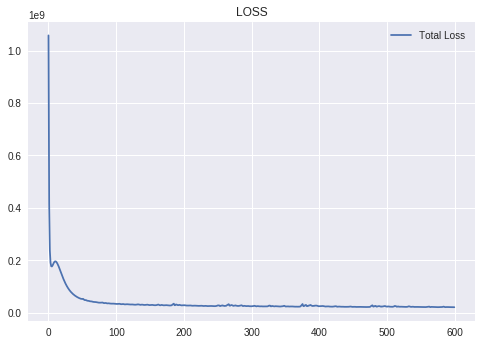

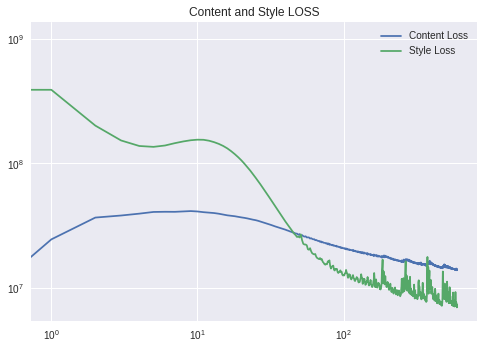

In [0]:
x_loss, y_loss = zip(*losses)
plt.plot(x_loss, y_loss, label='Total Loss')
plt.legend()
plt.title("LOSS")
plt.show()

cx_loss, cy_loss = zip(*c_losses)
plt.loglog(cx_loss, cy_loss, label='Content Loss')
sx_loss, sy_loss = zip(*s_losses)
plt.loglog(sx_loss, sy_loss, label='Style Loss')
plt.legend()
plt.title("Content and Style LOSS")
plt.show()




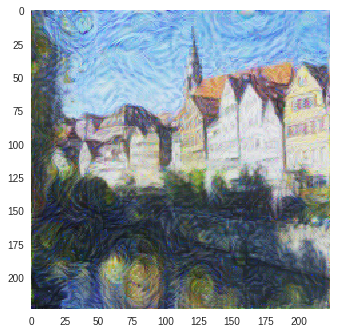

In [0]:
sig = nn.Sigmoid()

imgg = sig(gen_image).cpu().detach()
img = gen_image.cpu().detach()
# show(img)

import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

plt.grid(False)
plt.imshow(to_img(imgg.squeeze(0)))

torch.Size([1, 3, 224, 224])


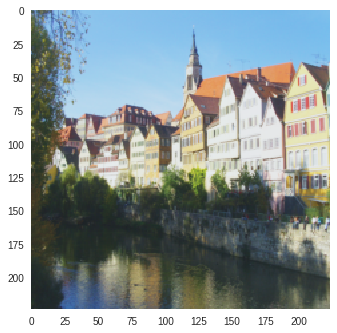

In [0]:
print(img.size())
plt.grid(False)
plt.imshow(to_img(sig(content_image.cpu().detach()).squeeze(0)))

torch.Size([1, 3, 224, 224])


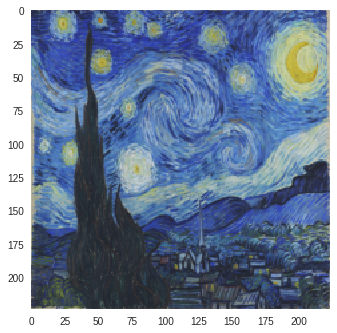

In [0]:
print(img.size())
plt.grid(False)
plt.imshow(to_img(sig(style_image.cpu().detach()).squeeze(0)))